In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [3]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
print("Download to..:",path_to_file)

Download to..: /Users/macico/.keras/datasets/spa-eng/spa.txt


### テキスト処理

In [4]:
#### Converts the unicode file to ascii
def unicode_to_ascii(s):
    #正規化；Normalization Form Decompose
    #汎用カテゴリ：http://www.unicode.org/reports/tr44/#General_Category_Values
    #Mn: 	Nonspacing_Mark	a nonspacing combining mark (zero advance width)
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

####  sentence preprocesser
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [1]:
## 指定データセットからnum_examples文だけ(enflish , spanish)作る
# ある程度分かち書きや正規化などはする。
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    

    return zip(*word_pairs)

In [12]:
### Sample ###
print(io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')[1])

en, sp = create_dataset(path_to_file, None)
print(sp[0],en[0])
print(sp[-1],en[-1])

Go.	Vete.
<start> ve . <end> <start> go . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end> <start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>


- tf.keras.preprocessing.text.Tokenizer(
- テキストをトークン化するユーティリティクラス．
    - 各テキストを整数の列（各整数はは辞書におけるトークンのインデックス）または単語のカウントやtf-idfなどに基づいて各トークンをバイナリとした係数からなるベクトルに変換することで，テキストコーパスをベクトル化します．
- テキストをベクトル化する，または/かつ，テキストをシーケンス（= データセット中でランクi（1から始まる）の単語がインデックスiを持つ単語インデックスのリスト）に変換するクラス．
- args
    - num_words: 利用する単語の最大数で単語の頻度に基づきます．一般的にはnum_words-1が用いられます．
    - filters: テキストからフィルタする文字の要素からなる文字列．デフォルトでは全ての句読点に加えてタブや開業，マイナス，'文字です．
    - lower: 真理値．テキストを小文字にするかどうか．
    - split: 文字列．単語を分割するセパレータ．
    - char_level: Trueなら，全文字はトークンとして扱われます．
    - oov_token: 与えられた場合，単語のインデックスに付与され，text_to_sequenceが呼ばれた時に語彙にない単語を入れ替えるために使われます．

In [29]:
#### 複数langに対して、ベクトル化
# tensor：　文字列を単純に分割したtensor
# tokenizer　：　固定長lang_tokenizer(tokenizerクラス)

def tokenize(lang):
    # Tokenizerをインスタンス化
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    # インスタンスに文章を与える。
    lang_tokenizer.fit_on_texts(lang)
    
#     print("#doc : ", lang_tokenizer.document_count)
#     print("#words in doc : \n", lang_tokenizer.word_counts)
#     print("index of word :",lang_tokenizer.word_index)

    #単語のシーケンス番号（1～）の列を示すベクトルが得られる。
    tensor = lang_tokenizer.texts_to_sequences(lang)
#     print(tensor)

    #固定長に変換
    #最大長指定なし→最大の文字長に合わせる
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

#ベクトル*文章数のテンソルのうち、最大次元数を返却
def max_length(tensor):
    return max(len(t) for t in tensor)

In [32]:
#### Make dataset ####
def load_dataset(path, num_examples=None):
    # creating data
    # get input and clean it , output pair
    targ_lang, inp_lang = create_dataset(path, num_examples)

    #to tensor
    #to tokrenize
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [41]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = \
    max_length(target_tensor), max_length(input_tensor)

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = \
    train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [37]:
### Sample ###
print([sp[0]])
tensor, lang_tokenizer = tokenize([sp[0]])
print(tensor)
#入力の文章数
print(lang_tokenizer.document_count)
#ターゲットの辞書
print(lang_tokenizer.word_counts)
# 単語ごとに割り当て当てられたインデックス番号
print(lang_tokenizer.word_index)

def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

##　ちゃんと対応取れているよ！
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

['<start> ve . <end>']
[[1 2 3 4]]
1
OrderedDict([('<start>', 1), ('ve', 1), ('.', 1), ('<end>', 1)])
{'<start>': 1, 've': 2, '.': 3, '<end>': 4}
Input Language; index to word mapping
1 ----> <start>
9 ----> el
1144 ----> llevaba
5907 ----> jeans
5908 ----> puestos
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
14 ----> he
99 ----> had
2595 ----> jeans
44 ----> on
3 ----> .
2 ----> <end>


## Create a tf.data dataset

In [43]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
#埋め込み次元
embedding_dim = 256
#En/decoderにおけるユニット数
units = 1024
# 辞書サイズ,
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

#文字列の配列をスライスすると、文字列のデータセット
#よしなにまとめてくれる
#シャッフルで
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
#バッチサイズに区切る
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [84]:
### Sample ###
example_input_batch, example_target_batch = next(iter(dataset))

# どちらもBATCH_SIZE＊(最大文字列長)
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

### Encoderの設置

In [85]:
#エンコーダーは入力文字が各ユニットにどの程度重みをつけるかを計算する。
class Encoder(tf.keras.Model):
    #vocab_size: 辞書サイズ,
    #embedding_dim: 隠れ層サイズ
    #enc_units: encodeのユニット数
    #batch_sz: バッチサイズ
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        
        #埋め込み
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        ## GRU:RNN以上LSTM以下のもの
        ## Gated Recurrent Unit
        # Glorot の正規分布（Xavier の正規分布とも呼ばれます）による初期化を実施
        # https://keras.io/ja/initializers/
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    #フォーワード計算を行う。
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    # 残りの初期化を行う 
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [86]:
# vocab_inp_size->embedding_dimに圧縮される
# units個だけUnitができる
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

###  サンプル入力 ###
sample_hidden = encoder.initialize_hidden_state()
# 試しに１バッチだけ入れてみる
# Call呼び出し
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, hidden units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, hidden units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, hidden units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, hidden units) (64, 1024)


### Attensionの設置 

In [87]:
class BahdanauAttention(tf.keras.layers.Layer):
    #units:コンテキストベクターとしてデコーダに渡すので、decodeerのunit数(もちろんencoderとおなじ)
    #BahdanauAttentionを使用
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        #encioder input
        self.W1 = tf.keras.layers.Dense(units)
        #decoder input
        self.W2 = tf.keras.layers.Dense(units)
        #score
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        # query : decoerの隠れ層の状態　： shape == (batch_size, hidden size)だけど
        #　行列にする必要があるので、(batch_size, 1, hidden size)とする
        #　最終的にqueryはencoderの出力における各言葉(文字列長分)に対して加算される
        #　＊＊tf.expand_dims　添字"axis"でのサイズ1の次元を加える
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # values: encoderの出力
        # values == (batch_size, max_length, hidden size)
        
        # スコアを self.V に適用するために最後の軸は 1 となる
        # self.V に適用する前のテンソル(tanh)の shape は  (batch_size, max_length,  hidden size)
        
        # Denceは和を計算(1次元)
        # ==> Scoreは関連度；　推測したい言葉(の状態)(target)から計算された出力(query：hidden_with_time_axis)を全てのencoder出力(values)から計算される。
        # transformerなら内積取るらしい
        score = self.V(
            tf.nn.tanh(
                self.W1(values) + self.W2(hidden_with_time_axis)
            )
        )
        #(batch_size, max_length,  hidden size):言葉の重みについてhidden size分だけ存在するのでソフトマックス
        # attention_weights の shape == (batch_size, max_length, 1)
        # encoder出力とdecoder隠れ層から現時点における各max_length分のユニット(言葉)に対し、attention_weightが作成される(batch_size分)
        attention_weights = tf.nn.softmax(score, axis=1)

        # attention_weights の shape == (batch_size, max_length, 1)
        # values 　　　　　　　　　　　　== (batch_size, max_length, hidden size)
        #　もととなる言葉のencoder出力に計算済みの言葉の重みをかければ、現時点(＝文脈)におけるencoder出力を鑑みた算出される各言葉に対する重みが計算
        context_vector = attention_weights * values
        
        #　axis+1次元目で総和を取る
        # context_vector の合計後の shape == (batch_size, hidden_size)
        # 各encoder出力において言葉の重みを集約データのどこにattentionを向けるのかを判定
        #　ｑuery と　valueで毎回全結合層のアップデートが掛かるので常に更新
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [88]:
###  サンプル入力 ###
nb_of_hidden = 10
attention_layer = BahdanauAttention(nb_of_hidden)
#encodeerのテストで作成済み
# sample_hidden:deoderの隠れ層の状態
# sample_output:encoder出力
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

#Contextは各
print("Attention result shape(context vector): (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

print(tf.expand_dims(sample_hidden, 1).shape)
print(sample_output.shape)
# W1= tf.keras.layers.Dense(units)
W2 = tf.keras.layers.Dense(units)
# print(W1(sample_output)) #64,16,1024
# print(W2(tf.expand_dims(sample_hidden, 1))) #(64, 1, 1024)
# print(W1(sample_output)  + W2(tf.expand_dims(sample_hidden, 1))).shape #(64, 16, 1024)

Attention result shape(context vector): (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)
(64, 1, 1024)
(64, 16, 1024)


### decoderの設置

In [107]:

class Decoder(tf.keras.Model):
    
    #vocab_size: 辞書サイズ(出力側はまた違うサイズ)
    #embedding_dim: 隠れ層サイズ
    #dec_units: decodeのユニット数
    #batch_sz: バッチサイズ
    
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # アテンション設定
        # decoderの隠れ層に対して設置される
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        #　まず、decoderの隠れとencorderのアウトプットからアテンション計算
        # context_vector, attention_weightsを得る
        # enc_output の shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
        # GRUへは直列で渡す
        # tf.concat : Negative axis are interpreted as counting from the end of the rank, i.e., axis + rank(values)-th dimension.
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 結合したベクトルを GRU 層に渡す
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights
    
    ## decoderは隠れの初期化は不要。：encoderを引き継ぐので、

In [102]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

###  サンプル入力 ###
sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


### オプティマイザと損失関数の定義

In [91]:
#  adamにする
optimizer = tf.keras.optimizers.Adam()

# Computes the crossentropy loss between the labels and predictions.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

#mean
def loss_function(real, pred):
    # element wiseで０でないかを判定
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    # paddingした部分を入力としないように位置をmaskingする
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### チェックポイント（オブジェクトベースの保存

In [92]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### 訓練
- 
- エンコーダーの出力とエンコーダーの隠れ状態、そしてデコーダーの入力（これが 開始トークン）がデコーダーに渡される
- デコーダーは 予測値 と デコーダーの隠れ状態 を返す
- つぎにデコーダーの隠れ状態がモデルに戻され、予測値が損失関数の計算に使用される
- デコーダーへの次の入力を決定するために Teacher Forcing が使用される
- Teacher Forcing は、正解単語 をデコーダーの 次の入力 として使用するテクニックである
- 最後に勾配を計算し、それをオプティマイザに与えて誤差逆伝播を行う

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    # デコレータはtf.sessionのようなもの。コレをつけるだけで高速化する
    #モデルと振る舞いを組み立てる
    loss = 0

    #GradientTape とは勾配を求めるためのクラス
    #内部でtapeで記録された変数は自動的に
    with tf.GradientTape() as tape:
        
        #入力をエンコーダーに通すと、エンコーダー出力とエンコーダーの隠れ状態 が返される
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        #状態の共有
        dec_hidden = enc_hidden

        #1文字ずつdecoderに入れていく
        #初期値は'<start>'に相当する辞書index（＊バッチサイズ）
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)

            # Teacher Forcing を使用 - 正解値を次の入力として供給
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    #tf.keras.Model.trainable_variablesを呼び出すことで、そのネットワークに含まれる重みをリストとして得られる
    variables = encoder.trainable_variables + decoder.trainable_variables

    #得られた変数について、微分→更新
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    


    

    return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,batch,batch_loss.numpy()))
            
    # 2 エポックごとにモデル（のチェックポイント）を保存
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [65]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [66]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


Input: <start> hace mucho frio aqui . <end>
Predicted translation: voted voted voted voted voted voted voted voted voted voted voted 


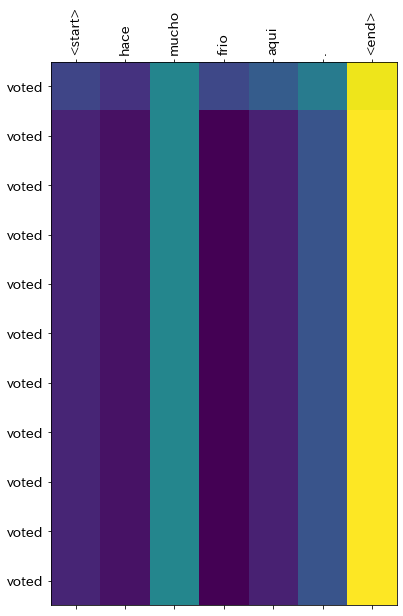

In [68]:
translate(u'hace mucho frio aqui.')